
# Implementación de Caminatas Cúanticas Alternadas en Gŕaficas.

## Preeliminares

Importamos los módulos necesarios y definimos funciones auxiliares.

In [1]:
from qiskit import *
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram,plot_state_city
from qiskit.circuit.library import *
%matplotlib inline

In [2]:
from math import sqrt,log,ceil,floor,asin,pi
import numpy as np
import matplotlib.pyplot as plt

### Funciones para la creación de la matriz de Representaciones Binarias

Estas matrices son una representación de los conjuntos de estados de la base computacional que corresponden a cada clique.

In [3]:
def BinaryRepLSF(n, length = 1):
    """
    Returns an np array of minimum length 'length' integers representing the binary form of
    'n'.
    """
    rep = []
    power = 0
    while n>0:
        mul = 2**power
        coc = n/(2*mul)
        res = (2*mul)*(coc-floor(coc))
        rep.append(int(res/mul))
        n-=res
        power+=1
    if len(rep)<length:
        for i in range(length -len(rep)):
            rep.append(0)
    return np.array(rep)

In [4]:
def BinaryMatrix(P,length=1):    
    BM = [BinaryRepLSF(p, length) for p in P]
    return np.array(BM)

### Construcción del Árbol de Control

A continuación se declara la clase *Node* que utilizamos para construir el arbol de control.

In [5]:
class Node:
    def __init__(self,zb,ob,val = 0,parent = None ,level=None,
                 branch = None,rootinfo = None,c = "" ):
        """
        Node class for a 'control tree'
        """
        self.parent = parent
        self.zb = zb
        self.ob = ob
        self.branch = branch
        self.val = val
        self.level = level
        if rootinfo != None:
            self.rootinfo = rootinfo
        self.c = c
    def setzb(self,newzb):
        self.zb = newzb
        newzb.parent = self
        newzb.branch = 0
        if self.branch != None:
            #newzb.c = self.c + str(self.branch)
            newzb.c = str(self.branch)+self.c
    def setob(self,newob):
        self.ob = newob
        newob.parent = self
        newob.branch = 1
        if self.branch != None:
            #newob.c = self.c + str(self.branch)
            newob.c = str(self.branch)+self.c
    def setp(self,newp):
        self.parent = p
    def getlevel(self):
        if self.level == None:
            if self.parent == None:
                self.level = 0
            else:
                self.level = self.parent.getlevel()+1
        return self.level
    def recursive_print(self,rl = None,branch=None):
        cl = self.getlevel()
        if rl == None:
            rl = cl
            message = "\t"*(cl-rl)+"v="+str(self.val)+" croot"
        else:
            message = "\t"*(cl-rl)+str(self.branch)+" v="+str(self.val)+" c="+self.c
        print(message)
        if self.zb != None:
            self.zb.recursive_print(rl,0)
        if self.ob != None:
            self.ob.recursive_print(rl,0)
        

Aquí definimos la función *BuildControlTree* que construye el árbol de control a partir de la matrix de bits *BM*.

In [6]:
def BuildControlTree(BM):
    """
    Builds control Tree from BitMatrix BM.
    Returns the root node of the control tree.
    """
    root = Node(None,None,val = 1,rootinfo = {})
    subBCT(BM,root)
    return root

def subBCT(subBM,p=None):
    """
    Main subroutine of BuilControlTree.
    """
    #print(subBM)
    brl = len(subBM[0])
    t = len(subBM)
    s = 0
    obm = []
    zbm = []
    for brep in subBM:
        if brep[0] == 1:
            s+=1
            obm.append(brep[1:])
        else:
            zbm.append(brep[1:])
    obm = np.array(obm)
    zbm = np.array(zbm)
    ob = Node(None,None,s/t,branch= 1)
    zb = Node(None,None,1-(s/t),branch= 0)
    p.setob(ob)
    p.setzb(zb)
    if brl != 1:
        if 0<s<t:
            #print("Both branches called.")
            subBCT(obm,ob)
            subBCT(zbm,zb)
        elif s==0:
            #print("Only 0 branch called.")
            #print(zbm)
            subBCT(zbm,zb)
        elif s==t:
            #print("Only 1 branch called.")
            #print(obm)
            subBCT(obm,ob)

A continuación definimos *sCRYGate*. 

In [7]:
def sCRYGate(s,c = "", inv = False):
    """
    Given an s value and a clist of previous control qubits
    builds a controled Y Rotation Gate.
    """
    theta =2* asin(sqrt(abs(s)))
    if inv:
        theta = -theta
    if len(c)>0:
        #print("Crate RY(%.2f) con C = %s"%(theta,c))
        return RYGate(theta).control(len(c),"",c)
    else:
        return RYGate(theta)

def WGate(rootn,n):
    """
    Builds the WGate of P_i given the root node of the
    control tree of P_i on the quantum Circuit qc.
    Returns qc as a Gate Object.
    """
    
    qc = QuantumCircuit(n)
    #The queue for BFS is initialized.
    queue = [rootn.ob,rootn.zb]
    s = rootn.ob.val
    qc.append(sCRYGate(s,rootn.c),[0])
    #Main Loop of BFS
    #queue = [rootn]
    while len(queue) > 0:
        #print([str(nd.c)+str(nd.branch) for nd in queue])
        active = queue.pop(0)
        #c= active.c+str(active.branch)
        c= str(active.branch)+active.c
        #print(c)
        if active.ob != None:
            s = active.ob.val
            cs = range(len(c)+1)
            if  s!=0:
                gate = sCRYGate(s,c)
                qc.append(gate,cs)
                #print("Added YRot(%.2f) with target %i and controls %s"%(s,len(c),cs))
            queue.append(active.ob)
        if active.zb != None:
            queue.append(active.zb)
    return qc.to_gate()

def WGateInv(rootn,n):
    """
    Builds the $W^\dagger$ Gate of $P$ given the root node of the
    control tree of $P$ on the quantum Circuit qc.
    Returns qc as a Gate Object.
    """
    qc = QuantumCircuit(n)
    #The queue for BFS is initialized.
    queue = [rootn.ob,rootn.zb]
    s = rootn.ob.val
    qc.append(sCRYGate(s,rootn.c,True),[0])
    #Main Loop of BFS
    while len(queue) > 0:
        #Get the first node in the queue
        active = queue.pop(0)
        c= str(active.branch)+active.c
        if active.ob != None:
            s = active.ob.val
            cs = range(len(c)+1)
            #If the required rotation is not trivial proceed
            if  s!=0:
                #Creates and adds to the circuit a
                # controlet RY Gate with control state s
                gate = sCRYGate(s,c,True)
                qc.append(gate,cs)
            #Adds the o-branch of active to the queue
            queue.append(active.ob)
        if active.zb != None:
            #Adds the z-branch of active to the queue
            queue.append(active.zb)
    return qc.to_gate().mirror()

def W(P, N = 0):
    """
    Given the list $P$ builds the $W_P$ gate with $N$
    qubit registers. Returns a Gate Object.
    """
    M = max(P)
    if N == 0:
        while M>=2**N:
            N += 1
    rootp = BuildControlTree(BinaryMatrix(P,N))
    G = WGate(rootp,N)
    G.label = "$W_{"+str(P)+"}$"
    return G

def WInv(P, N = 0):
    """
    Given the list $P$ builds the $W_P^\dagger$ gate with $N$
    qubit registers. Returns a Gate Object.
    """
    M = max(P)
    if N == 0:
        while M>=2**N:
            N += 1
    rootp = BuildControlTree(BinaryMatrix(P,N))
    G = WGateInv(rootp,N)
    G.label = "$W^\dagger_{"+str(P)+"}$"
    return G




Mostramos un ejemplo usando $P=[5,1]$ a 4 *qubits*.

In [8]:
NQ = 4
Q = QuantumCircuit(NQ,NQ)
Q.append(W([5,1,2],NQ),range(NQ))
#Q.append(WInv([5,1],NQ),range(NQ))
#Q.append(WGateInv(r,3),range(3))
#Q.add_register(ClassicalRegister(3))

for i in range(NQ):
    Q.measure(i,i)

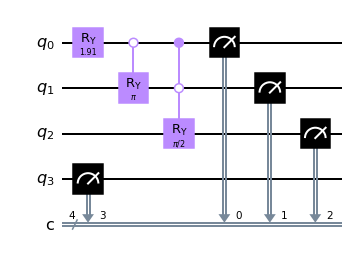

In [9]:
Q.decompose().draw(output="mpl")

Simulando este circuito vemos que tenemos la misma probabilidad de medir $5$, $2$ o $1$ pues el estado final del circuito es $\frac{1}{\sqrt{3}} (\left| 1\right>+\left| 2\right>+\left| 5\right>)$

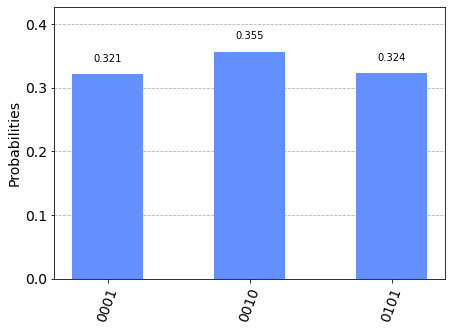

In [10]:
qasm = Aer.get_backend('qasm_simulator')
job = execute(Q, qasm, shots=4000)
result = job.result()
counts = result.get_counts(Q)
plot_histogram(counts)

## Operadores de Difusión

### Operador de Difusión de Grover

In [11]:
def S_0(N):
    """
    Returns Grover's $S_0$ gate with N qubit entries.
    """
    qc = QuantumCircuit(N)
    qc.x(N-1)
    S = ZGate().control(N-1, "","0"*(N-1))
    qc.append(S,range(N))
    qc.x(N-1)
    G = qc.to_gate()
    G.label = "S_0"
    return G

Ejemplo de $S_0(4)$:

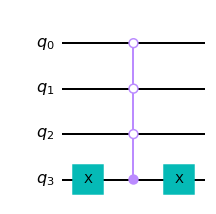

In [12]:
NQ = 4
Q = QuantumCircuit(NQ)
Q.append(S_0(NQ),range(NQ))
Q.decompose().draw(output= "mpl")

Introducimos el estado $\left.|0\right>$ y vemos que efectivamente cambia de signo. Es decir, es una implementación de $-S_0$ tal como es planteada en el texto, sin embargo sólo introduce un factor de fase global a diferencia de $S_0$. Esto será corregido posteriormente con la implementación de $\mathcal{U}$.

In [13]:
backend = BasicAer.get_backend('statevector_simulator') # the device to run on
result = execute(Q, backend).result()
psi  = result.get_statevector(Q)
psi

array([-1.-7.82877306e-16j,  0.+0.00000000e+00j,  0.+0.00000000e+00j,
        0.+0.00000000e+00j,  0.+0.00000000e+00j,  0.+0.00000000e+00j,
        0.+0.00000000e+00j,  0.+0.00000000e+00j,  0.+0.00000000e+00j,
        0.+0.00000000e+00j,  0.+0.00000000e+00j,  0.+0.00000000e+00j,
        0.+0.00000000e+00j,  0.+0.00000000e+00j,  0.+0.00000000e+00j,
        0.+0.00000000e+00j])

## Operador de Difusión $S_P$

Con todo esto finalmente podemos contruir la función que construye la compuerta $S_{P} = W_P S_0 W_P^\dagger$ dado $P$.

In [14]:
def S(P,N):
    """
    Given P a polygon, as a list, and N 
    returns the Difussion Gate of P with N quibits. 
    """
    qc = QuantumCircuit(N)
    qc.append(WInv(P,N),range(N))
    qc.append(S_0(N),range(N))
    qc.append(W(P,N),range(N))
    G = qc.to_gate()
    G.label = "$S_{"+str(P)+"}$"
    return G


Presentamos un ejemplo con $P = [0,2]$ a $3$ *qubits*. Vemos que al introducir $\frac{1}{\sqrt{2}}\left(\left| 0\right>+\left| 2\right>\right)$ obtenemos el mismo estado pues implementamos $-S_0$ en lugar de $S_0$.

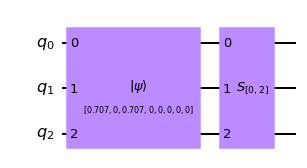

In [15]:
Q = QuantumCircuit(3)
Q.initialize([1/sqrt(2),0,1/sqrt(2),0,0,0,0,0],range(0,3))
Q.append(S([0,2],3),range(3))

Q.draw(output='mpl')

In [16]:
qasm = Aer.get_backend('qasm_simulator')
backend = BasicAer.get_backend('statevector_simulator') # the device to run on
result = execute(Q, backend).result()
psi  = result.get_statevector(Q)
print(psi)

[-0.70710678-1.26164559e-15j  0.        +0.00000000e+00j
 -0.70710678-1.23310295e-15j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j]


Sin embargo si introducimos cualquier estado que no tenga componente en $\left|\beta_P \right>$ solo cambia de signo. En este ejemplo introducimos $\frac{1}{\sqrt{2}}\left(\left| 1\right>+\left| 3\right>\right)$

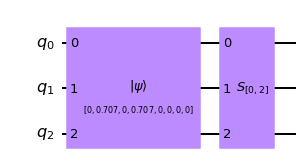

In [17]:
Q = QuantumCircuit(3)
Q.initialize([0,1/sqrt(2),0,1/sqrt(2),0,0,0,0],range(0,3))
Q.append(S([0,2],3),range(3))

Q.draw(output='mpl')


In [18]:
qasm = Aer.get_backend('qasm_simulator')
backend = BasicAer.get_backend('statevector_simulator') # the device to run on
result = execute(Q, backend).result()
psi  = result.get_statevector(Q)


El estado Final es:

In [19]:
print(psi)

[0.        +0.00000000e+00j 0.70710678+1.21625936e-15j
 0.        +0.00000000e+00j 0.70710678+1.14845276e-15j
 0.        +0.00000000e+00j 0.        +0.00000000e+00j
 0.        +0.00000000e+00j 0.        +0.00000000e+00j]


Vemos que el estado final y el inicial sólo difieren en un signo.

### Implentación de $\mathcal{U}$ y $\mathcal{H}$
Utilizamos la implementación desarrollada en el texto.  La funcion $\mathcal{U}_\mathcal{T} (\mathcal{T},\tau,N)$ toma la teselación $\mathcal{T}$ y devuelve la compuerta $\mathcal{U}(\tau)$ a $N+1$ *qubits* (automaticamente añade el qubit de control en la última posición).

In [20]:
def H(T,N,tname = ""):
    """
    Expects T a tesselation as a List of Lists and N the number of
    qubits required for the vertex space.
    Returns the hamiltonian Gate object with N entries.
    """
    qc = QuantumCircuit(N,name="$\mathcal{H}_{"+tname+"}$")
    #Computes the Difussion Gate por every polygon in the tessellation
    for P in T:
        qc.append(S(P,N),range(N))
    HG = qc.to_gate()
    
    HG.label = "$\mathcal{H}_{$"+str(T)+"}$"
    return HG

def U(T,tau, N,tname="" ):
    """
    Expects T a tesselation as a List of Lists, tau a real number and N the number of
    qubits required for the vertex space.
    Returns the U Gate object with N+1 entries. Adds a control qubit at the end of the quantum
    register.
    """
    #Definition of the controlled hamiltonian gate
    CH = H(T,N,tname).control(1)
    CH.label = "$C-\mathcal{H}_{"+str(T)+"}$"
    cs = [N]+[i for i in range(0,N)]
    
    #Initialize the template circuit
    qc = QuantumCircuit(N+1,name ="$\mathcal{U}("+str(tau)+")_{"+tname+"}$")
    
    #Adding the gates according to 4.13
    qc.h(N)
    qc.append(CH,cs)
    qc.z(N)
    qc.rx(-2*tau,N)
    qc.append(CH,cs)
    #qc.z(N)
    qc.h(N)
    qc.x(N)
    
    #Label and convert to gate the quantum circuit qc
    UG = qc.to_gate()
    UG.label = "$\mathcal{U}("+str(tau)+")_{"+tname+"}$"
    return UG



Mostramos un ejemplo con 3 *qubits*.

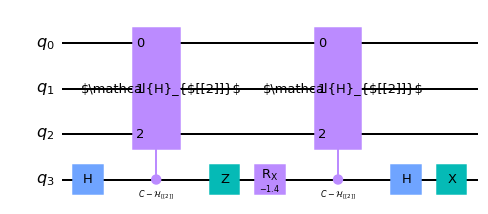

In [21]:
Q = QuantumCircuit(3+1)
"""Q.initialize(
[
    0,0,0,0,
    1,0,0,0,
    0,0,0,0,
    0,0,0,0
],range(0,4)
)"""
Q.append(U([[2]],0.7,3),range(3+1))
Q.decompose().draw(output='mpl')

In [22]:
qasm = Aer.get_backend('qasm_simulator')
backend = BasicAer.get_backend('statevector_simulator') # the device to run on
result = execute(Q, backend).result()
psi  = result.get_statevector(Q)
print(psi)

[ 7.64842187e-01-6.44217687e-01j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
 -1.16573418e-15+4.99600361e-16j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]


# Construcción del Modelo para una Gráfica Arbitraria

Usamos el módulo _networkx_ para crear y manipular gráficas.

In [23]:
import networkx as nx

Creamos una pequeña gráfica aleatoria $G$ de $n$ vértices y $m$ aristas.

In [ ]:
n = 6
m = 5
G = nx.dense_gnm_random_graph(n, m)
while not nx.is_connected(G):
    G = nx.dense_gnm_random_graph(n, m)
nx.draw_spring(G,with_labels= True,font_size=12,font_weight='bold',node_color='#9494e4')

Generamos listas y diccionarios que nos permiten relacionar los vertices de $H$ *extG* con la gráfica original $G$. Simultaneamente creamos la teselación de vertices $\mathcal{T}_V$ y la de aristas $\mathcal{T}_E$.

In [ ]:

#Given the H vertex number returns a G vertex number
ExtGtoG = []
#Given the G vertex number returns the list of G vertex numbers
GtoExtG = []
#Given a (u,v) pair of G vertices returns the H vertex number
PairtoExtG = {}
#Given the H vertex number returns the (u,v) pair of G vertices 
ExtGtoPair = []

T_V = []
T_E = []

ExtGVertexNumber = 0
#Iteration over the G vertices
for v in G.nodes():
    #print("v =",v)
    vlist = []
    #Iteration over the neighbourhood of v
    for u in G.adj[v]:
        #print("\t",u,"\t",ExtGVertexNumber)
        PairtoExtG[(v,u)]=ExtGVertexNumber
        ExtGtoG.append(v)
        ExtGtoPair.append((v,u))
        vlist.append(ExtGVertexNumber)
        ExtGVertexNumber +=1
    GtoExtG.append(vlist)

#The vertex tesellation is given directly by 
T_V = GtoExtG
print("T_V = ",T_V)

for pair in G.edges():
    v = pair[0]
    u = pair[1]
    p_E = [PairtoExtG[(v,u)],PairtoExtG[(u,v)]]
    T_E.append(p_E)
print("T_E = ",T_E)

Esta es una función auxiliar para generar las subgráficas completas.

In [ ]:
import itertools

def complete_graph_from_list(L):
    Ga = nx.empty_graph(len(L))
    if len(L)>1:
        edges = itertools.combinations(L,2)
        Ga.add_edges_from(edges)
    return Ga

Aquí generamos y mostramos la grafica extendida $H$.

In [ ]:
ExtG = nx.Graph()

#Generation of complete subgraphs of H
for v in G.nodes():
    ExtG= nx.compose(complete_graph_from_list(GtoExtG[v]),ExtG)
#Linking the complete subgraphs
for p_E in T_E:
    ExtG.add_edge(p_E[0],p_E[1])
pairlabels = {}
for v in ExtG.nodes():
    pairlabels[v] = str(ExtGtoPair[v])+" : "+str(v)

nx.draw_spring(ExtG,labels=pairlabels,font_size=10,font_weight='bold',node_color='#A4A4F4')

Ahora procedemos a implementar una SQW en la gráfica extendida con las teselaciones $\mathcal{T}_V$ y $\mathcal{T}_E$ usando las funciones descritas en las secciones anteriores. El siguiente código genera un cirucito cuántico que realiza la caminata con un número de iteraciones *steps* y $\tau = \pi/2$.

In [ ]:
NV = ceil(log(m,2)+1)
steps = 3
tau = pi/2
SQW = QuantumCircuit(NV+1,name="$SQW^{%i}_{\tau = %.2f}$"%(steps,tau))
#Calculation of the evolution gates
U_V = U(T_V,tau,NV,tname="V")
U_E = U(T_E,tau,NV,tname="E")
#Repeated alternation of the evolution gates
for i in range(steps):
    SQW.append(U_V,range(NV+1))
    SQW.append(U_E,range(NV+1))
#SQW = SQW.to_gate()

#for i in range(NV):
#    SQW.measure(i,i)
SQW.draw(output='mpl')

### Page Rank

En esta sección implementamos nuestra aproximación al algoritmo *PageRank* utilizando una SQW.

In [ ]:

steps =20
tau = pi/2
SQW = QuantumCircuit(NV+1,name="$SQW^{%i}_{\tau = %.2f}$"%(steps,tau))
#Calculation of the evolution gates
U_V = U(T_V,tau,NV,tname="V")
U_E = U(T_E,tau,NV,tname="E")
#Repeated alternation of the evolution gates
for i in range(steps):
    SQW.append(U_V,range(NV+1))
    SQW.append(U_E,range(NV+1))
SQW = SQW.to_gate()

Inicializamos el sistema en una superposición homogénea de todos los vértices de la gráfica extendida. Esto lo logramos mediante la aplicación de una compuerta $W_{V_H}$.

In [ ]:

QPR = QuantumCircuit(NV+1,NV)
QPR.append(W(range(2*m),NV),range(NV))
QPR.append(SQW,range(NV+1))

for i in range(NV):
    QPR.measure(i,i)

In [ ]:
#circ = transpile(QPR, qasm, optimization_level=1)

Simulamos el circuito y medimos el estado de los *qubits* corrspondientes a los vértices al final de cada experimento.

**Esta celda es computacionalmente intensiva.**

In [ ]:

job = execute(QPR, qasm, shots=400)
result = job.result()
counts = result.get_counts(QPR)
plot_histogram(counts)

Usando las listas creadas al momento de extender la gráfica $G$ convertimos los datos anteriores en un histograma sobre los vértices de $G$. Graficamos la probabilidad de medir la partícula en cada vértice con barras azules en la figura siguiente. Esta probabilidad corresponde con el *PageRank* de cada partícula.

El módulo *networkx* provee una implementación del algoritmo *PageRank* clásico mediante la función *pagerank*. Graficamos los resultados del algoritmo clásico con barras naranjas y los comparamos con nuestra propuesta cuántica.

In [ ]:

vcounts = [0 for i in range(n)]
for register in counts.items():
    v = ExtGtoG[int(register[0],2)]
    vcounts[v]+= register[1]
totalvcounts = sum(vcounts)
vcounts = [cc/totalvcounts for cc in vcounts]
plt.bar(range(n),vcounts,alpha=0.6,label="QPR")
print(vcounts)

CPR = nx.pagerank(G,alpha=0.85)
print(CPR.values())
plt.bar(range(n),CPR.values(),alpha=0.6,label="Classic PR")

plt.legend()
plt.plot()